In [126]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
from sklearn.cluster import KMeans

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils.network_analysis import *
from utils.neural_embedding import *

In [127]:
def edgelistToAdjacencyDict(filepath):
    """Read in edgelist and compute adjacency dictionary of structure {congressmember : adjacency_row} where 
       adjacency row is the congressmember's row in the adjacency following matrix
    """

    df = pd.read_csv(filepath, header=None).rename(columns = {0 : 'congressmember', 1 : 'followee'})
    pivot_df = df.pivot_table(index = 'congressmember', columns='followee', aggfunc='size', fill_value=0)
    binary_pivot_df = (pivot_df > 0).astype(int)
    index_array_dict = {idx: row.values for idx, row in binary_pivot_df.iterrows()}

    return index_array_dict

In [128]:
def computePCA(embedding_dict, n=2):
    """Compute n Principal components of sample data. 
    
    Args:
        - embedding_dct (dict) : Dictionary of sample names and feature vector, of structure {'name' : np.array}
        - n (int) : Number of Principal components to calculate

    Returns:
        - pca_dict (dct) : Dictionary of sample names and feature vector of principcal components, of structure {'name' : np.array}. Dim of np.array = n
    """
    # Extract names and vectors
    names = list(embedding_dict.keys())
    vectors = np.array(list(embedding_dict.values()))

    # Perform PCA
    pca = PCA(n_components=n)
    reduced_vectors = pca.fit_transform(vectors)

    # Create a new dictionary with the reduced vectors
    pca_dict = {name: reduced_vectors[i] for i, name in enumerate(names)}

    return pca_dict



In [136]:
def plotPCA(pca_dict, democrats_congress_members, republicans_congress_members):
    """Plot up to 2 principcal components of PCA vectors (or 1 if only 1 available)
    
    Args:
        - pca_dct (dict) : Dictionary of sample names and feature vector of principcal components, of structure {'name' : np.array}
        - democrats_congress_members (list) : list of democrat congress members
        - republicans_congress_members (list) : list of republican congress members

    Returns:
        - pca_dct_reduced (dict) : pca_dct reduce to <=2 principcal components (the vector being plotted). Returns pca_dct if <=2 already.
    """

    # If more than 2 components, reduce to 2 components for plotting
    n_components = len(list(pca_dict.values())[0])
    pca_dict_reduced = pca_dict.copy()
    if n_components > 2:
        print(f'Reducing {n_components} principal components to 2')
        for i in pca_dict_reduced:
            pca_dict_reduced[i] = pca_dict_reduced[i][:2]


    democrats_dict = {}
    republicans_dict = {}

    for congressperson in pca_dict:
        if congressperson in democrats_congress_members:
            democrats_dict[congressperson] = pca_dict[congressperson]
        elif congressperson in republicans_congress_members:
            republicans_dict[congressperson] = pca_dict[congressperson]

    with plt.style.context("ggplot"):
        # Plotting the 2D vectors
        plt.figure(figsize=(7, 5))

        if n_components == 1:
            for name, vector in democrats_dict.items():
                plt.scatter(vector[0], 0, label='democrat', color='navy')
            for name, vector in republicans_dict.items():
                plt.scatter(vector[0], 0, label='republican', color='red')
                #plt.annotate(name, (vector[0], 0))
        else:
            for name, vector in democrats_dict.items():
                plt.scatter(vector[0], vector[1], label='democrat', color='navy')
            for name, vector in republicans_dict.items():
                plt.scatter(vector[0], vector[1], label='republican', color='red')
                #plt.annotate(name, (vector[0], vector[1]))

        plt.title('PCA Components 1 and 2 of Network following data', size=10)
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        plt.legend()
        plt.grid(True)
        plt.show()

    return pca_dict_reduced

def computeKMeans(data_dict, k=2):
    # Convert the dictionary values to a NumPy array
    features = np.array(list(data_dict.values()))

    # Initialize and fit the KMeans algorithm
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)

    # Get the cluster labels
    labels = kmeans.labels_

    # If you want to associate labels with the original names:
    labeled_data = dict(zip(data_dict.keys(), labels))

    # Plotting
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 5))
        colors = ['red', 'navy',]  # Extend this list for more clusters

        for i in range(k):
            # Plot data points that are assigned to each cluster
            plt.scatter(features[labels == i, 0], features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')

        plt.title('Cluster visualization')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.grid(True)
        #plt.show()

    return labeled_data

In [137]:
# Read in congressmember to party mapping table
filepath = 'data/raw/all_congress_members.csv'
all_congress_members = pd.read_csv(filepath).drop_duplicates('twitter_name')
all_congress_members['congressperson'] = all_congress_members.new_twitter_name.where(all_congress_members.new_twitter_name.notnull(),all_congress_members.twitter_name).str.lower() #Get new/old username as required

democrats = all_congress_members[all_congress_members['party'] == 'D']
republicans = all_congress_members[all_congress_members['party'] == 'R']

democrats_congress_members = list(democrats['congressperson'])
republicans_congress_members = list(republicans['congressperson'])

In [166]:
pca_num = 1
house_dicts = {}
for n, i in enumerate([1,5,50,100,200]):
    for m, j in enumerate([1,2,3,5,10]):
        house_path = f'data/processed/senate_edgelist_kout{i}_kin{j}.csv'
        #a = computePCA(edgelistToAdjacencyDict(house_path),pca_num)
        #a = {key :value[-1] for key,value in a.items()}
        house_dicts[f'{n}_{m}'] = (computePCA(edgelistToAdjacencyDict(house_path),pca_num), f'kout{i}_kin{j}')
        #house_dicts[f'{n}_{m}'] = (a, f'kout{i}_kin{j}')


In [168]:
def plotPCAsubplots(pca_dict, democrats_congress_members, republicans_congress_members, ax):
    kin_kout = pca_dict[1]
    pca_dict = pca_dict[0]
    n_components = len(list(pca_dict.values())[0])
    pca_dict_reduced = pca_dict.copy()
    if n_components > 2:
        print(f'Reducing {n_components} principal components to 2')
        for i in pca_dict_reduced:
            pca_dict_reduced[i] = pca_dict_reduced[i][:2]

    democrats_dict = {}
    republicans_dict = {}

    for congressperson in pca_dict:
        if congressperson in democrats_congress_members:
            democrats_dict[congressperson] = pca_dict[congressperson]
        elif congressperson in republicans_congress_members:
            republicans_dict[congressperson] = pca_dict[congressperson]

    with plt.style.context("ggplot"):
        if n_components == 1:
            for name, vector in democrats_dict.items():
                ax.scatter(vector[0], 0, label='Democrat', color='navy')
            for name, vector in republicans_dict.items():
                ax.scatter(vector[0], 0, label='Republican', color='red')
        else:
            for name, vector in democrats_dict.items():
                ax.scatter(vector[0], vector[1], label='Democrat', color='navy')
            for name, vector in republicans_dict.items():
                ax.scatter(vector[0], vector[1], label='Republican', color='red')

        ax.set_title(f'PCA Components 1 and 2 ({kin_kout})', size=10)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        #ax.legend()
        ax.grid(True)


def plotPC1vsDW(pca_dict, democrats, republicans, chamber,ax):
    kin_kout = pca_dict[1]
    pca_dict = pca_dict[0]
    first_pca_df = pd.DataFrame.from_dict(pca_dict, orient='index').reset_index().rename(columns = {'index' : 'congressperson', 0 : 'first_pc'})


    democrats = democrats.merge(first_pca_df, on='congressperson', how='left')
    republicans = republicans.merge(first_pca_df, on='congressperson', how='left')
    democrats = democrats[democrats['chamber'] == chamber].dropna(subset=['first_pc'])
    republicans = republicans[republicans['chamber'] == chamber].dropna(subset=['first_pc'])


    with plt.style.context("ggplot"):
        x1 = democrats['DW-Nominate']
        y1 = democrats['first_pc']

        x2 = republicans['DW-Nominate']
        y2 = republicans['first_pc']
        
        ax.scatter(x1,y1, label='democrats', color='navy')
        ax.scatter(x2, y2, label='republicans', color='red')

        ax.set_title(f'PC1 vs. DW-Nominate score({kin_kout})', size=10)
        ax.set_xlabel('DW-Nominate')
        ax.set_ylabel('PC1')
        #ax.legend()
        ax.grid(True)

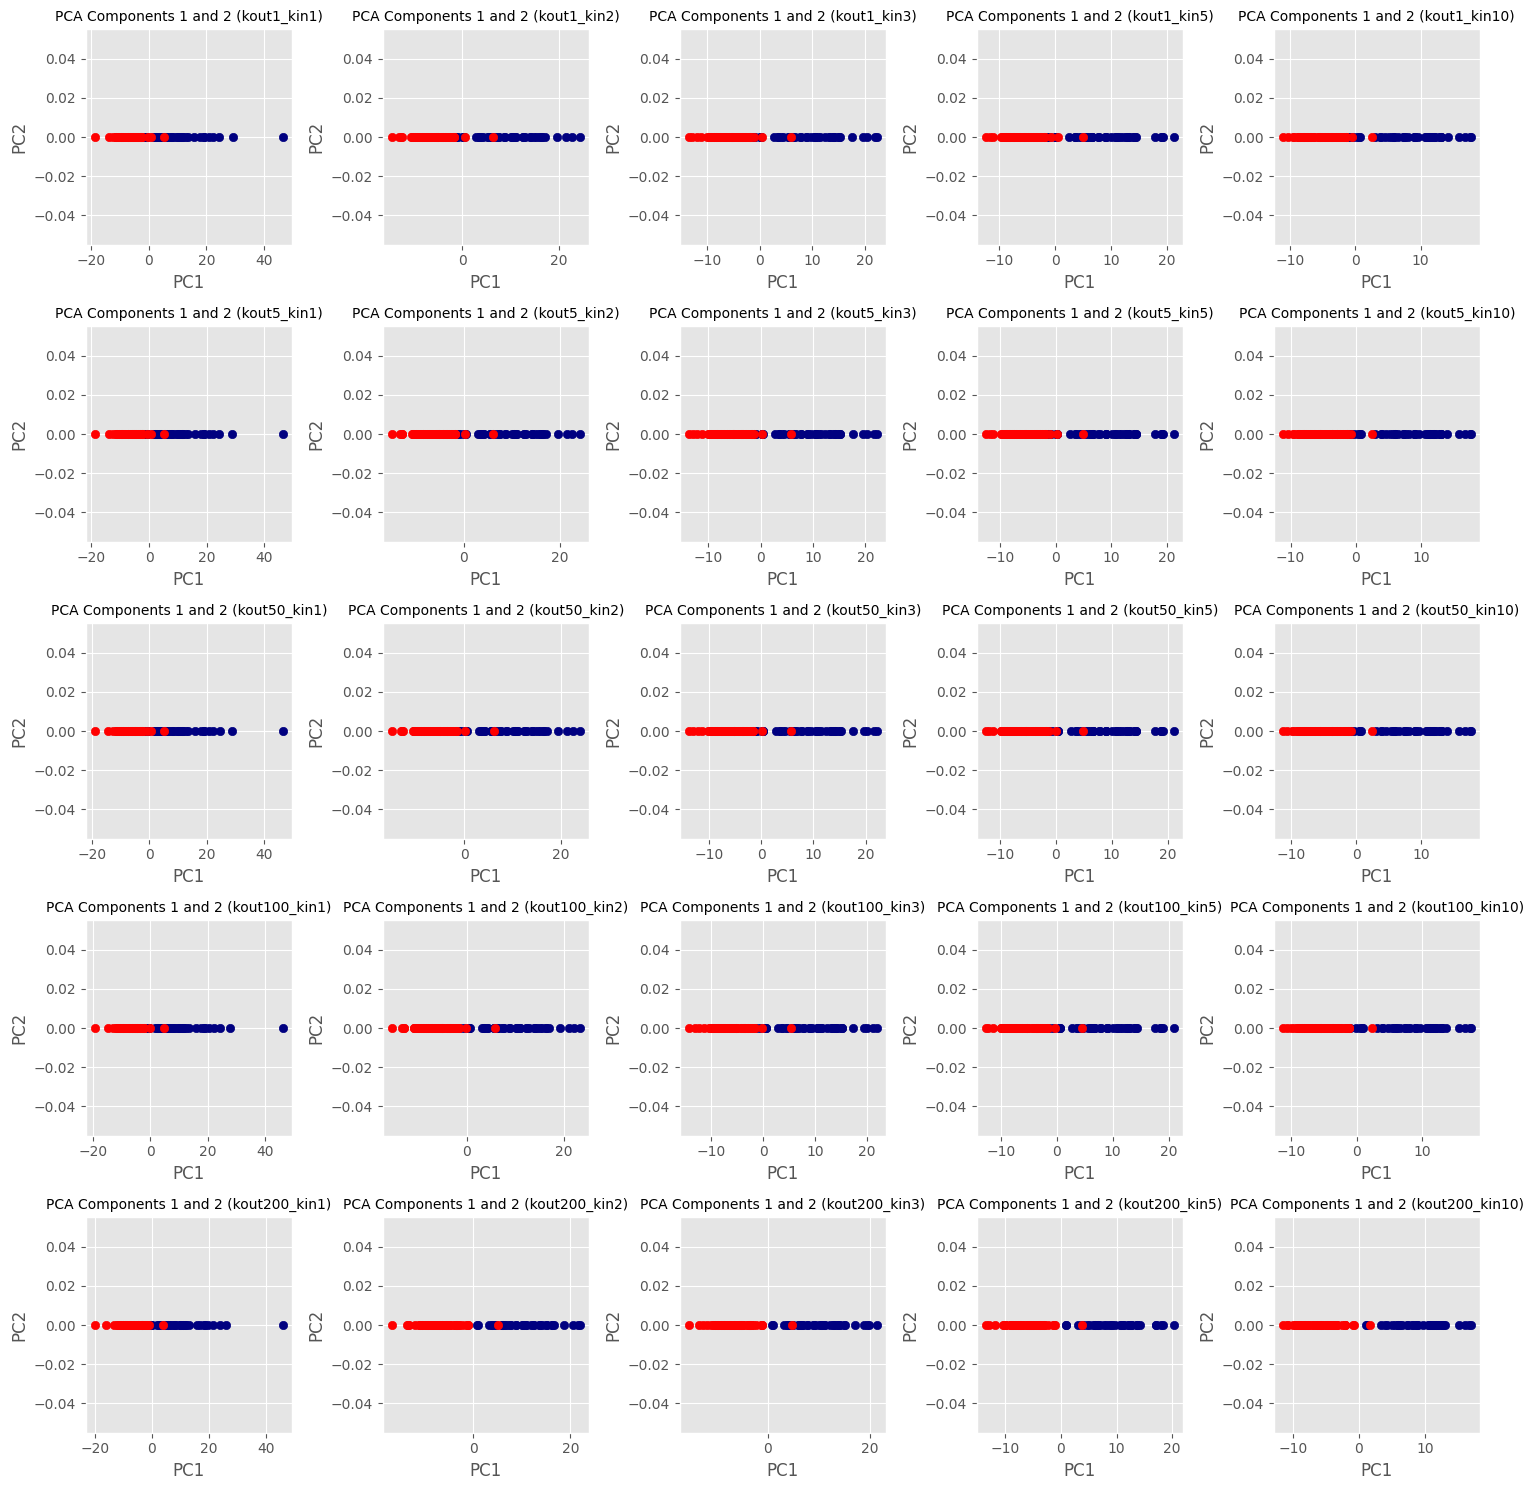

In [156]:
with plt.style.context("ggplot"):
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(5):
        for j in range(5):
            # Generate or select different pca_dict, democrats, republicans for each subplot
            # For example, you might have lists or a generator that provides these.
            plotPCAsubplots(house_dicts[f'{i}_{j}'], democrats_congress_members, republicans_congress_members, ax=axes[i, j])
    plt.tight_layout()
    #plt.savefig('senate_pca_only.pdf', format='pdf', dpi=400)
    plt.show()

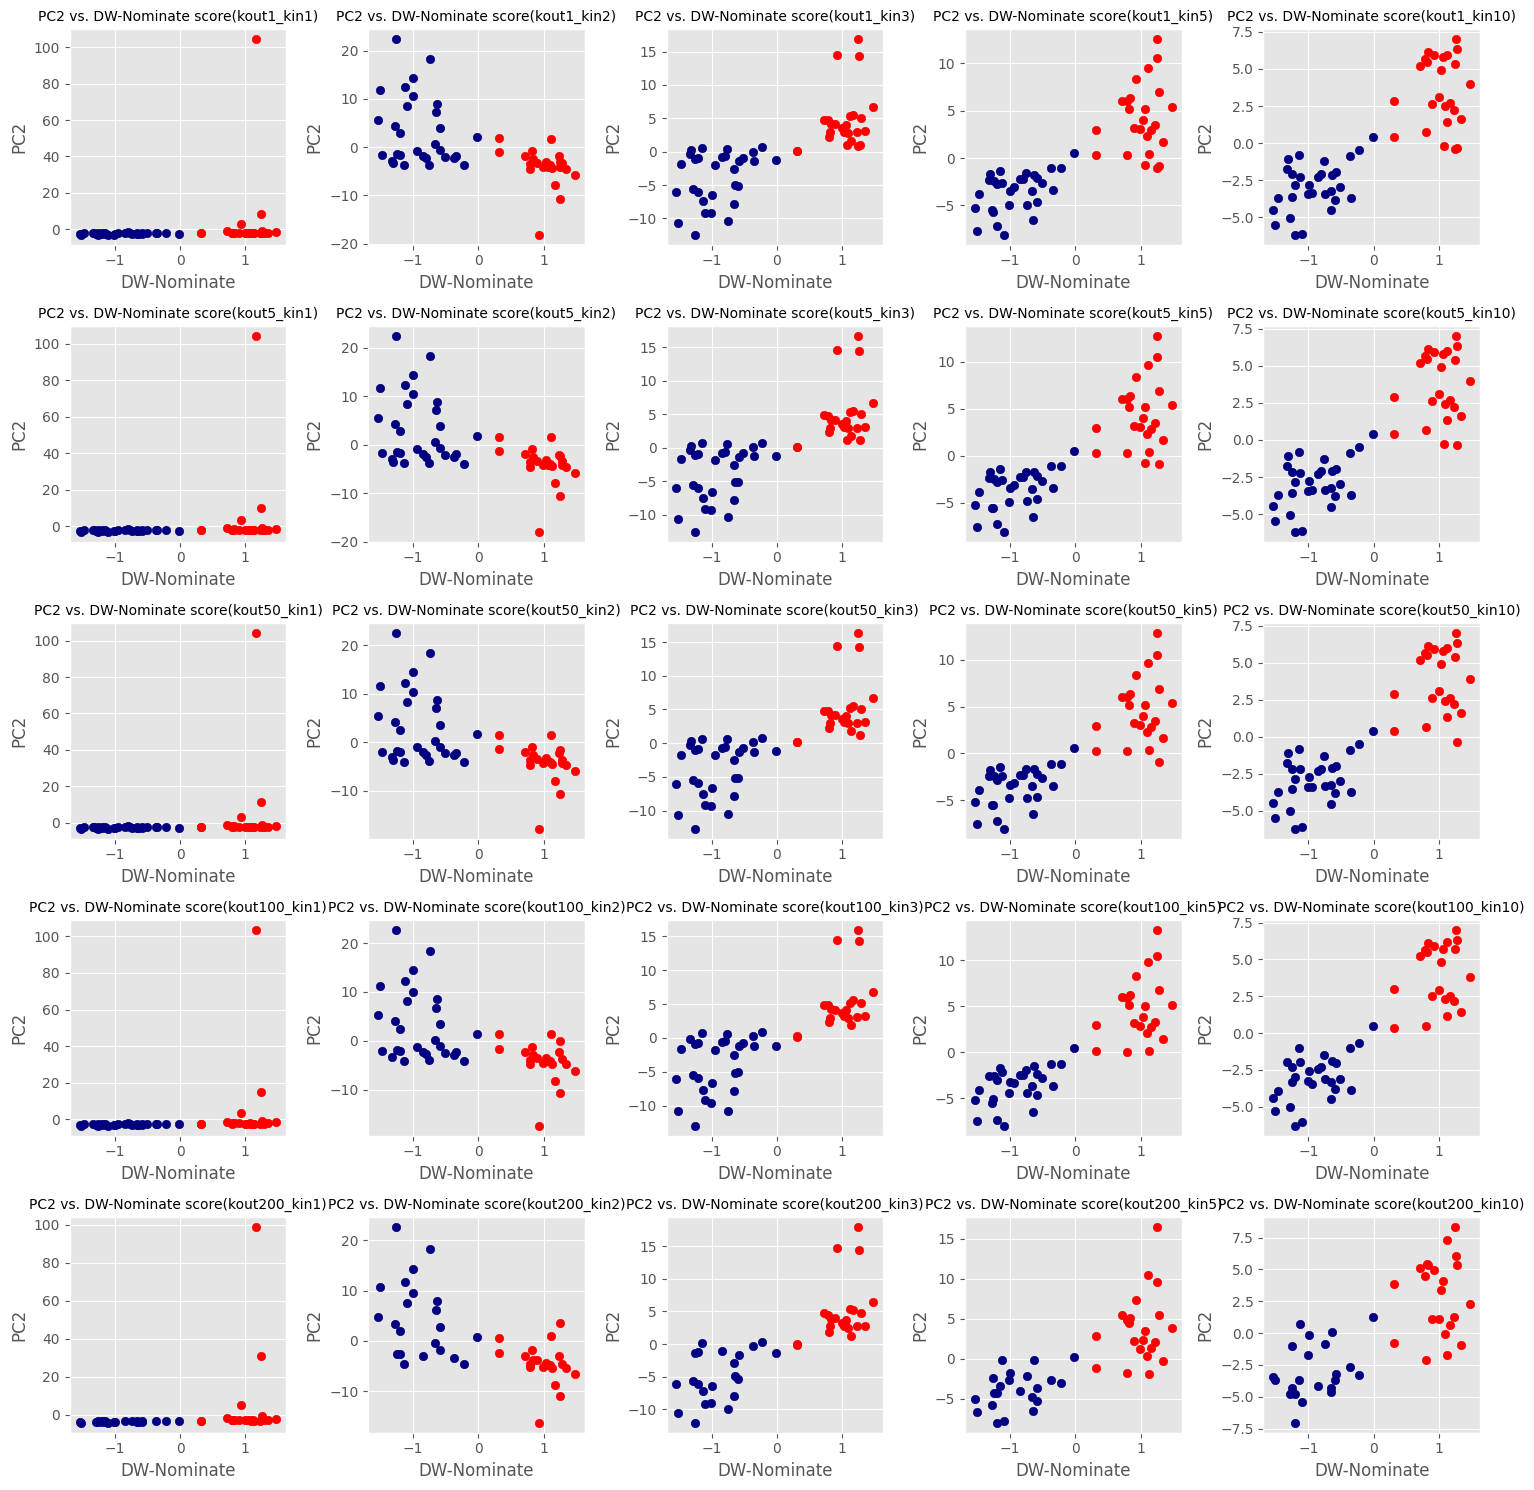

In [170]:
with plt.style.context("ggplot"):
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(5):
        for j in range(5):
            # Generate or select different pca_dict, democrats, republicans for each subplot
            # For example, you might have lists or a generator that provides these.
            plotPC1vsDW(house_dicts[f'{i}_{j}'], democrats, republicans, chamber='Senate',ax=axes[i, j])
    plt.tight_layout()
    plt.savefig('senate_pca_only_pc2_vs_DW.pdf', format='pdf', dpi=400)
    plt.show()

In [18]:
# Compute first 2 principal components
pca_dict = computePCA(adjacency_dict, 2)

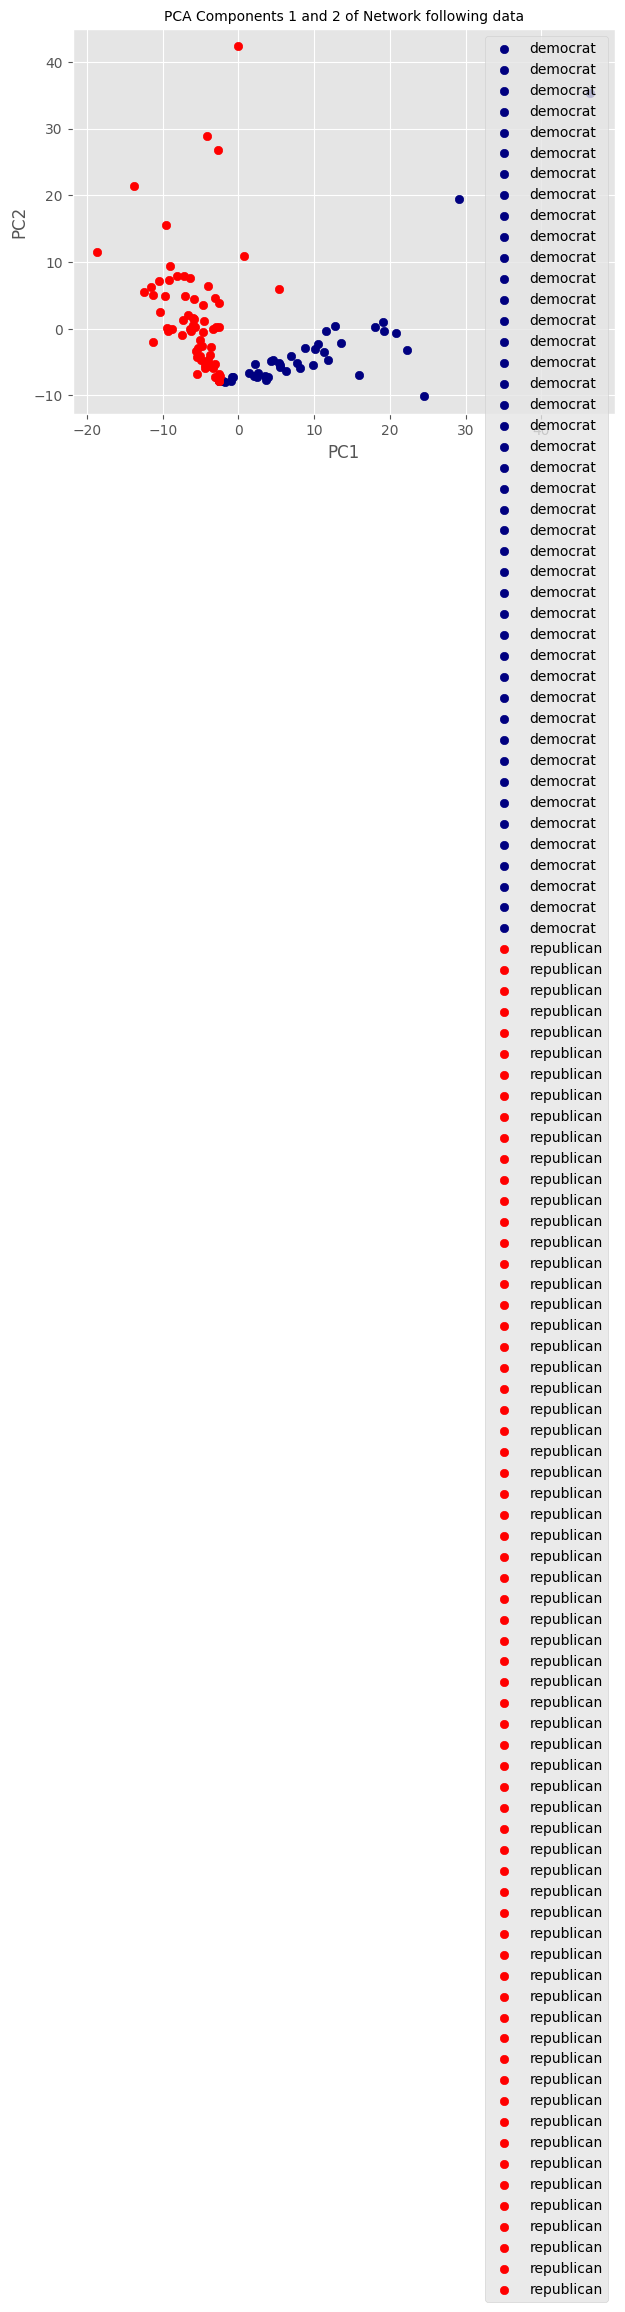

In [135]:
rd = plotPCA(pca_dict,democrats_congress_members , republicans_congress_members)

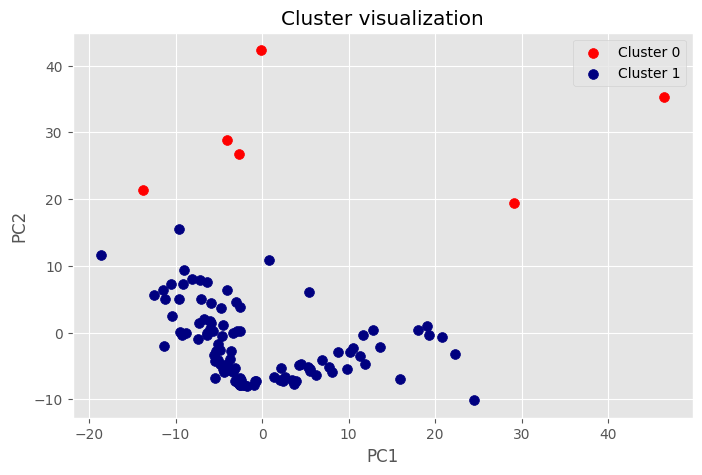

In [26]:
kmeans_classes = computeKMeans(pca_dict,2)